In [1]:
import numpy as np


In [2]:
m = 12
n = 13
nfp = 2
data = np.loadtxt("path0040.txt",
                  skiprows = 1, delimiter = ",")

In [7]:
def carttotorcil(data, R0):
    """
    Función que devuelve las estructuras de datos en los sistemas coordenados 
    necesarios para el cálculo de área y de error local/promedio. 

    data :: estructura de datos proporcionada de la solución de la ecuación 
    diferencial. 

    R0: Radio mayor del SCR-1 o dispositivo.
    """
    x, y, z, b, bx, by, bz = data.T
    R = np.sqrt(x**2+y**2)

    phi = np.arctan2(y,x)
    posp = np.where(phi<0)
    phi[posp] = phi[posp]+2*np.pi

    Br = bx*np.cos(phi)+by*np.sin(phi)
    Bphi = -bx*np.sin(phi)+by*np.cos(phi)
    rtor = np.sqrt((R-R0)**2+z**2)
    theta = np.arctan2(z, (R-R0))+np.pi
    post = np.where(phi<0)
    phi[post] = phi[post]+2*np.pi

    datastruct1 = np.array([R, phi, z, theta, b, Br, Bphi, bz]).T

    return datastruct1

In [4]:
datastruct = carttotorcil(data, 0.2477)

In [8]:
def initialize_data(data, nplanes):
    '''
    Inicializa los datos, en "nplanes" planos seleccionados del intervalo [0, 2pi] 
    para realizar el ajuste de parámetros. 

    data :: datos a analizar. 
    '''
      
    torplanes = np.linspace(0, 2*np.pi, num=nplanes, endpoint=False)
    dphi = 0.01
    phi_up = torplanes + dphi/2
    phi_down = torplanes - dphi/2
    R0 = 0.2477 

    boolarr = [np.logical_and(
                    data[:,1] < phi_up[i],
                    data[:,1] > phi_down[i]) for i in range(len(torplanes))]
                    #comparativo para los nplanes. 
    
    boolarr = np.array(boolarr).any(axis = 0)
    pos = np.where(boolarr)[0]
    data = data[pos]
    
    R = data[:,0]
    phi = data[:,1]
    z = data[:,2]
    theta = data[:,3]
    B = data[:,4]
    Br = data[:,5]
    Bphi = data[:,6]
    Bz = data[:,7]

    return np.array([R, phi, z, theta,B, Br, Bphi, Bz])

In [10]:
fitdata = initialize_data(datastruct, 100)

In [11]:
import torch as tor
from torch.nn.parameter import Parameter

In [12]:
def seriesargs(theta, phi, m, n, nfp, coord) -> tor.Tensor:
    funcs = []
    mvect = tor.arange(m+1)
    nvect = tor.arange(-n,n+1)
    M, N = tor.meshgrid(mvect, nvect)
    i = tor.einsum('ij,k', M, theta)
    j = tor.einsum('ij,k', N*nfp, theta)
    if coord == 'R':
        x = tor.cos(i-j)
    else: 
        x = tor.sin(i-j)
    
    return x

In [13]:
rdata, phi, zdata, theta, *_ = tor.from_numpy(fitdata.astype(np.float32))

In [14]:
cosmat = seriesargs(theta, phi, m, n, nfp, 'R')

In [40]:
params = tor.rand(m+1, 2*n+1)
params.requires_grad = True
optimizer = tor.optim.SGD({params}, lr=0.001, momentum=0.4)

In [41]:
plot = np.zeros((5000,2))
for i in range(5000):
    if i % 500 == 0: print(i)
    optimizer.zero_grad()
    R = tor.einsum('ij,ijk', params, cosmat)
    loss = tor.mean((rdata-R)**2)
    loss.backward()
    optimizer.step()
    plot[i,0] = i
    plot[i,1] = loss

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [17]:
import matplotlib.pyplot as plt

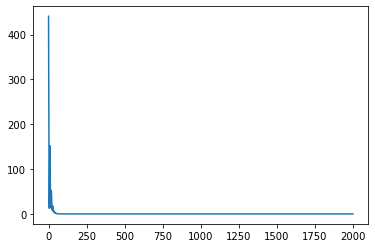

In [31]:
plt.plot(plot[:,0], plot[:,1])

In [34]:
print(rdata) 
tor.einsum('ij,ijk', params, cosmat)

tensor([0.2211, 0.2211, 0.2211,  ..., 0.2482, 0.2483, 0.2483])


tensor([0.2280, 0.2280, 0.2280,  ..., 0.2484, 0.2484, 0.2484],
       grad_fn=<ViewBackward>)